In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from indicators import *
from marketsimcode import *
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
import matplotlib.pyplot as plt

In [2]:
def pull_prices(symbol, sd, ed):
    """
        helper method for reading in and preprocessing the prices data

        inputs:
            symbol: string representing the stock symbol for trading
            sd:     string representing the date to start trading
            ed:     string representing the date to stop trading

        output:
            prices: dataframe containing the preprocessed daily price data
                    for the given stock
    """
    #reading in the stock data using util.py and removing nulls
    df = yf.download(symbol, start=sd, end=ed,
                     group_by="ticker", auto_adjust=True)
    prices = df.filter(items=['Close'],axis=1)
    prices.columns = [symbol]
    prices.fillna(method='ffill', inplace=True) #forward-filling missing prices
    prices.fillna(method='bfill', inplace=True) #back-filling missing prices
    return prices

In [3]:
def generate_indicators(prices, n):
    """
        helper method for generating features dataframe containing the
        training indicators

        inputs:
            prices:        dataframe containing the daily prices of a stock
            n:             integer representing the window for the stock price 
                           indicators

        output:
            indicators_df: dataframe containing the Price/SMA Ratio,
                           Bollinger Bands, and Volatility of the daily
                           stock prices
    """
    #creating the indicator dfs
    price_sma_df = price_sma_ratio(prices, n)
    bb_df = bollinger_bands(prices, n)
    vol_df = volatility(prices, n)

    #creating features dataframe for training the regressor
    indicators_df = price_sma_df.join(bb_df,rsuffix="1").join(vol_df,rsuffix="2")
    indicators_df.columns = ["Price/SMA", "Bollinger Bands", "Volatility"]
    
    #adding column for the closing price of two days prior
    indicators_df["Previous Price"] = prices.shift(2).values
    
    return indicators_df

In [4]:
def test_code(learner, orders_sl_df, sd, ed, symbol, sv, plot_title, plot_indicators_bool = False):
    #reading in SPY prices over the in-sample date range
    prices = learner.preprocess_data(symbol, sd, ed)
    #test trades using marketsimcode
    portvals_sl = compute_portvals(orders_sl_df, start_val = sv, commission=0.0, impact=0.005)

    prices['Strategy Learner'] = portvals_sl
    prices['Predicted Price'] = learner.prices_pred
    plot_winnings(prices, plot_title, ["Strategy Learner",
                  "Prices"], [], [])
    adr,sddr,cr = port_stats(portvals_sl)

    #if plot_indicators_bool == True, then plotting the indicator graphs
    if plot_indicators_bool:
        price_sma_plot(prices, n = 10)
        bb_plot(prices, n = 10)
        volatility_plot(prices, n = 10)

    # Print statistics
    print(f"Start Date: {sd}")
    print(f"End Date: {ed}")
    print(f"Symbol: {symbol}")
    
    print(f"SL: Std Dev of Daily Returns: %.5f"%sddr)
    print(f"SL: Average Daily Return: %.5f"%adr)
    print(f"SL: Cumulative Return: %.5f"%cr)

## In-Sample Period

In [5]:
#storing the symbol to trade, starting and ending dates for trading
symbol = 'AAPL'
sd = '2012-01-01'
ed = '2013-12-31'

#reading in adjusted closing prices
prices = pull_prices(symbol, sd, ed)

#normalizing the prices
ss = StandardScaler()
# ss.fit(prices)
prices_norm = pd.DataFrame(ss.fit_transform(prices),index=prices.index, columns=[symbol])

prices_norm.head()

[*********************100%***********************]  1 of 1 completed


,AAPL
Date,
2012-01-03,-1.584109
2012-01-04,-1.554680
2012-01-05,-1.493559
2012-01-06,-1.435369
2012-01-09,-1.444291


In [6]:
#generating the indicators from the price data
n = 10
indicators = generate_indicators(prices_norm, n)
#removing the first n rows of the indicators df to remove nulls 
indicators = indicators.iloc[n:,:]
#removing the first n rows of the prices df to match the indicators df
prices_norm = prices_norm.iloc[n:,:]
indicators.head()

,Price/SMA,Bollinger Bands,Volatility,Previous Price
Date,,,,
2012-01-18,-0.008674,1.345069,-0.287062,-1.469857
2012-01-19,-0.003027,0.999659,-0.286849,-1.404742
2012-01-20,0.013087,-0.920177,-0.285619,-1.346019
2012-01-23,-0.000839,0.763345,-0.285141,-1.364129
2012-01-24,0.013655,-0.899240,-0.284354,-1.463333


In [7]:
prices_norm.head()

,AAPL
Date,
2012-01-18,-1.346019
2012-01-19,-1.364129
2012-01-20,-1.463333
2012-01-23,-1.368656
2012-01-24,-1.461868


In [8]:
#using ridge regression to predict the stock prices
# model = make_pipeline(PolynomialFeatures(5),Ridge(alpha=0.8, random_state=0))
model = Ridge(alpha=0.001, random_state=0)
model.fit(indicators, prices_norm)
prices_pred = model.predict(indicators)

#scoring model
print("R-Squared of Model: %0.5f"%model.score(indicators, prices_norm))

R-Squared of Model: 0.98340


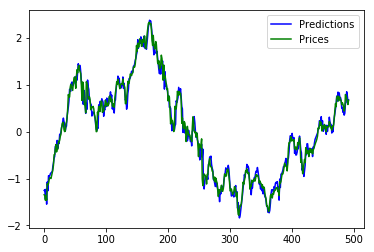

In [9]:
plt.plot(prices_pred, color='b', label='Predictions')
plt.plot(prices_norm.values, color='g', label='Prices')
plt.legend()
plt.show()

## Out-of-Sample Period 

In [10]:
#storing the symbol to trade, starting and ending dates for trading
symbol = 'AAPL'
sd = '2017-01-01'
ed = '2018-12-31'

#reading in adjusted closing prices
prices = pull_prices(symbol, sd, ed)

#normalizing the prices
prices_norm = pd.DataFrame(ss.transform(prices),index=prices.index, columns=[symbol])

#generating the indicators from the price data
n = 10
indicators = generate_indicators(prices_norm, n)
#removing the first n rows of the indicators df to remove nulls 
indicators = indicators.iloc[n:,:]
#removing the first n rows of the prices df to match the indicators df
prices_norm = prices_norm.iloc[n:,:]

prices_norm["Predicted Price"] = model.predict(indicators)
prices_norm.head()

[*********************100%***********************]  1 of 1 completed


,AAPL,Predicted Price
Date,,
2017-01-18,5.219129,5.093325
2017-01-19,5.197639,5.161877
2017-01-20,5.220154,5.186730
2017-01-23,5.228339,5.179504
2017-01-24,5.217082,5.156567



R-Squared of Model: 0.97905


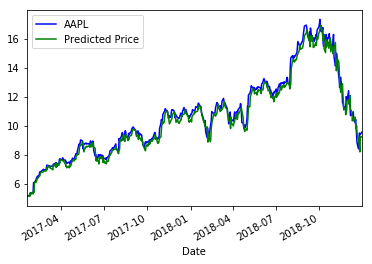

In [11]:
#scoring model
print()
print("R-Squared of Model: %0.5f"%model.score(indicators, prices_norm.iloc[:,0]))

prices_norm.plot(color=['b','g'])
# plt.plot(x=prices_norm.index, y=prices_pred, color='b', label='Predictions')
# plt.plot(x=prices_norm.index, y=prices_norm.values, color='g', label='Prices')
plt.legend()
plt.show()

In [12]:
from StrategyLearner import StrategyLearner

In [13]:
def test_code(learner, orders_sl_df, sd, ed, symbol, sv, plot_title):
    #reading in SPY prices over the in-sample date range
    prices = pull_prices(symbol, sd, ed).iloc[10:,:]
    #test trades using marketsimcode
    portvals_sl = compute_portvals(orders_sl_df, start_val = sv, commission=0.0, impact=0.005)

    prices['Strategy Learner'] = portvals_sl
    prices['Predicted Price'] = learner.prices_pred
    plot_winnings(prices, plot_title, ["Strategy Learner",
                  "Prices"], [], [])
    adr,sddr,cr = port_stats(portvals_sl)

    # Print statistics
    print(f"Start Date: {sd}")
    print(f"End Date: {ed}")
    print(f"Symbol: {symbol}")
    
    print(f"SL: Std Dev of Daily Returns: %.5f"%sddr)
    print(f"SL: Average Daily Return: %.5f"%adr)
    print(f"SL: Cumulative Return: %.5f"%cr)

In [14]:
#initializing objects
sl = StrategyLearner(n=10, learner=Ridge, kwargs={'alpha':0.001, 'random_state':0}, threshold = 0.0)

#in-sample parameters
symbol = "AAPL"
sd = "2008-01-01"
ed = "2011-12-31"

sv = 100000

print()
print("######################   In-Sample   #######################")
print()

#training Random Forest regressor
sl.addEvidence(symbol, sd, ed, sv)

#creating StrategyLearner orders dataframe
trades_sl_df = sl.testPolicy(symbol, sd, ed, sv)
orders_sl_df = sl.generate_orders_df(trades_sl_df, symbol)

#testing learner
test_code(sl, orders_sl_df, sd, ed, symbol, sv,
          "Strategy Learner vs %s (in-sample)"%symbol)


print()
print("######################  Out-of-Sample  ######################")
print()

#out-of-sample dates
sd = "2012-01-01"
ed = "2012-12-31"

#creating StrategyLearner orders dataframe
trades_sl_df = sl.testPolicy(symbol, sd, ed, sv)
orders_sl_df = sl.generate_orders_df(trades_sl_df, symbol)

test_code(sl, orders_sl_df, sd, ed, symbol, sv,
          "Strategy Learner vs %s (out-of-sample)"%symbol)


######################   In-Sample   #######################

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Start Date: 2008-01-01
End Date: 2011-12-31
Symbol: AAPL
SL: Std Dev of Daily Returns: 0.00312
SL: Average Daily Return: 0.00098
SL: Cumulative Return: 1.65065

######################  Out-of-Sample  ######################

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
Start Date: 2012-01-01
End Date: 2012-12-31
Symbol: AAPL
SL: Std Dev of Daily Returns: 0.00844
SL: Average Daily Return: 0.00315
SL: Cumulative Return: 1.10430


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

[*********************100%***********************]  1 of 1 completed


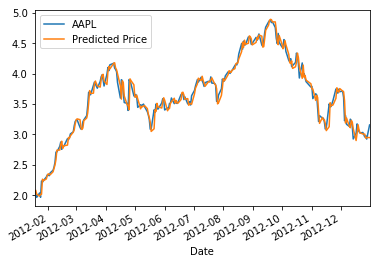

In [15]:
prices = pull_prices(symbol, sd, ed)
prices_norm = pd.DataFrame(sl.ss.transform(prices),index=prices.index, columns=[symbol]).iloc[n:,:]
prices_norm["Predicted Price"] = sl.prices_pred.values
prices_norm.plot()
plt.show()

In [16]:
print("Number of Predictions: %0.0f"%sl.trades)
print("Number of Mismatches: %0.0f"%sl.bad_trades)
print("Percent of Mismatches: %0.4f %%"%(100*np.divide(sl.bad_trades,sl.trades)))

Number of Predictions: 229
Number of Mismatches: 70
Percent of Mismatches: 30.5677 %
